In [1]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np


In [2]:
chess_board_size = (7, 5)
frame_size = (3840, 1080)
square_size = 29.0

In [5]:
import json

calibration_save_path = './calibration_saves'
with open(f'{calibration_save_path}/calibration.json', 'r') as f:
    calibration = json.load(f)

In [15]:
mapx_left = np.array(calibration['mapx_left'], dtype=np.float32)
mapy_left = np.array(calibration['mapy_left'], dtype=np.float32)
mapx_right = np.array(calibration['mapx_right'], dtype=np.float32)
mapy_right = np.array(calibration['mapy_right'], dtype=np.float32)
Q = np.array(calibration['Q'], dtype=np.float32)

In [14]:
mapx_left.dtype

dtype('float64')

In [16]:
def measure_distance(stereo_frame, stereo, mapx_left, mapy_left, mapx_right, mapy_right):
    frame_left = cv2.cvtColor(stereo_frame[:, : frame_size[0] // 2], cv2.COLOR_BGR2RGB)
    frame_right = cv2.cvtColor(stereo_frame[:, frame_size[0] // 2:], cv2.COLOR_BGR2RGB)

    grey_frame = cv2.cvtColor(stereo_frame, cv2.COLOR_BGR2GRAY)
    
    grey_frame_left = grey_frame[:, : frame_size[0] // 2]
    grey_frame_right = grey_frame[:, frame_size[0] // 2:]

    remap_left = cv2.remap(grey_frame_left, mapx_left, mapy_left, cv2.INTER_LINEAR)
    remap_right = cv2.remap(grey_frame_right, mapx_right, mapy_right, cv2.INTER_LINEAR)

    disparity = stereo.compute(np.uint8(remap_left), np.uint8(remap_right)).astype(np.float32) / 16.0

    plt.figure(figsize=(16, 9))

    plt.subplot(2, 2, 1)
    plt.imshow(frame_left)
    plt.axis('off')
    plt.subplot(2, 2, 2)
    plt.imshow(frame_right)
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(remap_left, cmap='gray')
    plt.axis('off')
    plt.subplot(2, 2, 4)
    plt.imshow(remap_right, cmap='gray')
    plt.axis('off')

    return disparity

In [17]:
stereo = cv2.StereoSGBM.create(
    minDisparity=0,
    numDisparities=128,
    blockSize=9,
    P1=8*3*9**2,
    P2=32*3*9**2,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32,
    disp12MaxDiff=1
)

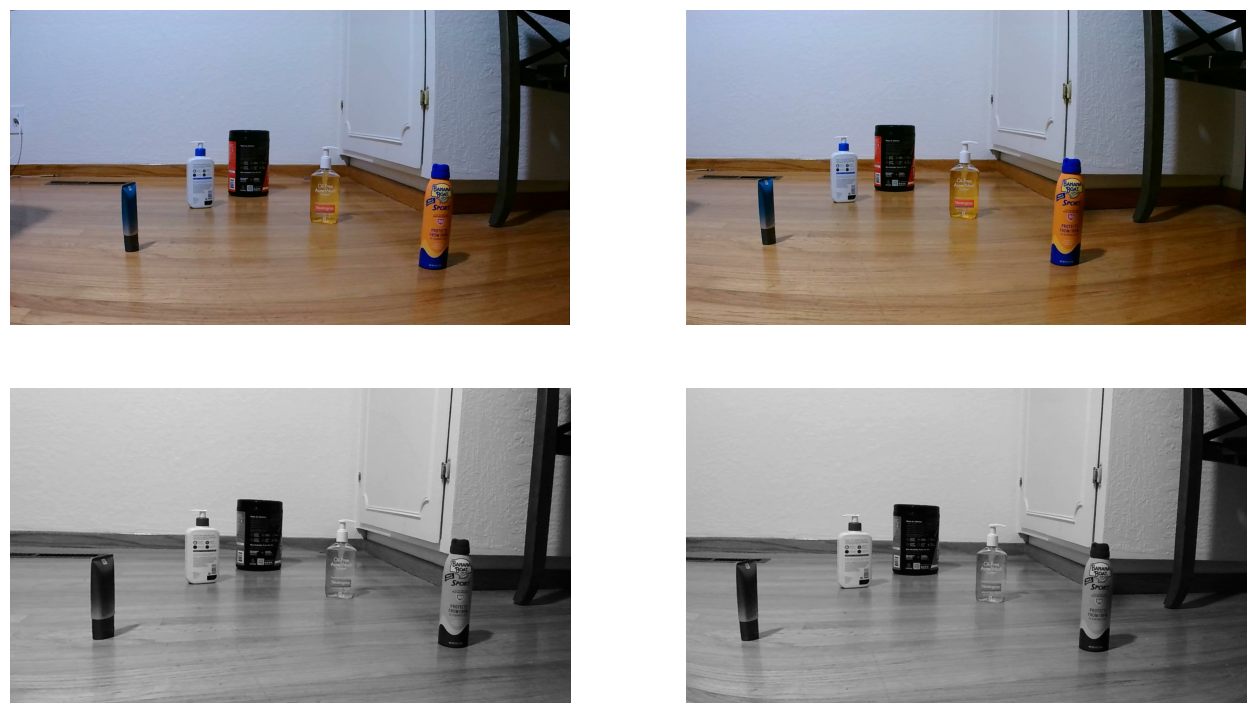

In [18]:
frame = cv2.imread('./depth_testing_images/img_0.jpg')
disparity = measure_distance(frame, stereo, mapx_left, mapy_left, mapx_right, mapy_right)

(np.float64(-0.5), np.float64(1919.5), np.float64(1079.5), np.float64(-0.5))

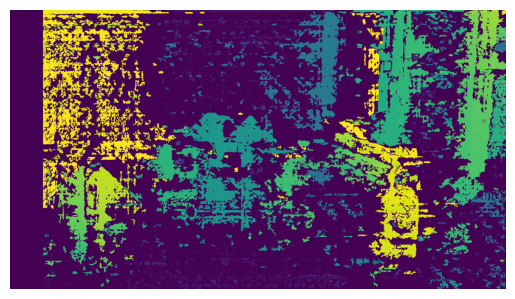

In [19]:
disp_vis = cv2.normalize(disparity, None, 0, 255, cv2.NORM_MINMAX)
disp_vis = np.uint8(disp_vis)
plt.imshow(disp_vis)
plt.axis('off')

Depth stats:
  Min: -89538.4140625
  Max: inf
  Mean: inf
  Valid points: 712156 / 2073600


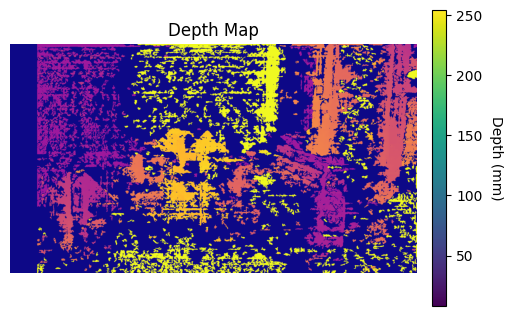

In [20]:
point_cloud = cv2.reprojectImageTo3D(disparity, Q)
depth = point_cloud[:, :, 2]
valid = np.isfinite(depth) & (depth > 0)

print("Depth stats:")
print(f"  Min: {np.nanmin(depth)}")
print(f"  Max: {np.nanmax(depth)}")
print(f"  Mean: {np.nanmean(depth)}")
print(f"  Valid points: {np.sum(valid)} / {depth.size}")

depth_vis = np.clip(depth, 300, 1500)  # Adjust these bounds as needed
depth_vis = cv2.normalize(depth_vis, None, 0, 255, cv2.NORM_MINMAX)
depth_vis = np.uint8(depth_vis)
depth_colored = cv2.applyColorMap(depth_vis, cv2.COLORMAP_PLASMA)

img = plt.imshow(cv2.cvtColor(depth_colored, cv2.COLOR_BGR2RGB))
plt.title("Depth Map")
plt.axis('off')

# Add colorbar with depth units
cbar = plt.colorbar(img, shrink=0.8, pad=0.03)
cbar.set_label('Depth (mm)', rotation=270, labelpad=15)

